This notebook introduces the use of the morphodynamical trajectory embedding method on a live-cell imaging dataset of MCF10A cells responding to EGF over 48 hours (30 minutes between frames), see Morphodynamical cell-state description via live-cell imaging trajectory embedding
Jeremy Copperman, Sean M. Gross, Young Hwan Chang, Laura M. Heiser, Daniel M. Zuckerman, bioRxiv (2021) doi: https://doi.org/10.1101/2021.10.07.463498
For celltraj code installation and python environment requirements, see installation instructions https://jcopperm.github.io/celltraj/installation.html

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import celltraj.trajectory

/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


An example dataset is available at https://figshare.com/articles/dataset/EGF1_17nov20_h5/20721685 which is an h5 file containing the raw images, cell segmentations, and foreground masks. Download this data and move to the same folder as this tutorial.

In [2]:
fileSpecifier = 'EGF1_17nov20.h5' #live-cell imaging data file with images, cell masks (labels), and foreground masks
modelName = 'mcf10a_EGF' #data label for outputs
sctm = celltraj.trajectory.Trajectory() #single-cell trajectory model (sctm) object
sctm.initialize(fileSpecifier, modelName)

In [9]:
sctm.get_frames() #get number of frames
start_frame=0
end_frame=sctm.maxFrame
sctm.get_imageSet(start_frame,end_frame) #pull image data into sctm for analysis
sctm.get_fmaskSet(start_frame,end_frame) #pull foreground/background masks

Frame 0 has 1 images...
Frame 1 has 1 images...
Frame 2 has 1 images...
Frame 3 has 1 images...
Frame 4 has 1 images...
Frame 5 has 1 images...
Frame 6 has 1 images...
Frame 7 has 1 images...
Frame 8 has 1 images...
Frame 9 has 1 images...
Frame 10 has 1 images...
Frame 11 has 1 images...
Frame 12 has 1 images...
Frame 13 has 1 images...
Frame 14 has 1 images...
Frame 15 has 1 images...
Frame 16 has 1 images...
Frame 17 has 1 images...
Frame 18 has 1 images...
Frame 19 has 1 images...
Frame 20 has 1 images...
Frame 21 has 1 images...
Frame 22 has 1 images...
Frame 23 has 1 images...
Frame 24 has 1 images...
Frame 25 has 1 images...
Frame 26 has 1 images...
Frame 27 has 1 images...
Frame 28 has 1 images...
Frame 29 has 1 images...
Frame 30 has 1 images...
Frame 31 has 1 images...
Frame 32 has 1 images...
Frame 33 has 1 images...
Frame 34 has 1 images...
Frame 35 has 1 images...
Frame 36 has 1 images...
Frame 37 has 1 images...
Frame 38 has 1 images...
Frame 39 has 1 images...
Frame 40 h

getting foreground masks frame: 82...
getting foreground masks frame: 83...
getting foreground masks frame: 84...
getting foreground masks frame: 85...
getting foreground masks frame: 86...
getting foreground masks frame: 87...
getting foreground masks frame: 88...
getting foreground masks frame: 89...
getting foreground masks frame: 90...
getting foreground masks frame: 91...
getting foreground masks frame: 92...
getting foreground masks frame: 93...
getting foreground masks frame: 94...
getting foreground masks frame: 95...
getting foreground masks frame: 96...


These are unlabeled phase contrast images of MCF10A mammary epithelial cells in 2D culture in EGF containing media. Lets see what these images look like

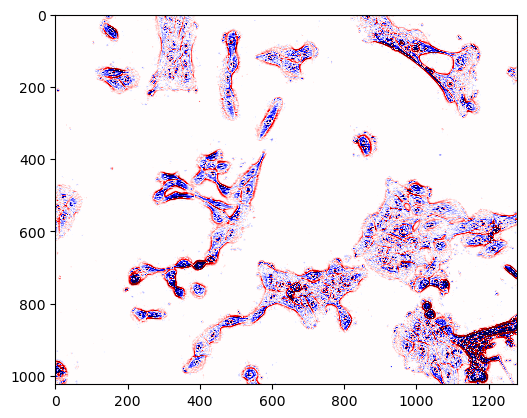

In [4]:
from IPython.display import clear_output
plt.clf()
for i in range(end_frame):
    clear_output(wait=True)
    plt.imshow(sctm.imgSet[i,:,:],cmap=plt.cm.seismic,clim=(-3,3))
    plt.pause(.2)

Let's have the sctm go through the cell labels in the image set and extract the single-cell features

In [17]:
sctm.get_imageSet_trans_turboreg() #register images
sctm.get_cell_data()  #gather single-cell label information
sctm.get_cell_images() #extract single-cell images
sctm.get_cellborder_images() #extract cellborder images
sctm.prepare_cell_images() #prepare single-cell images f
sctm.prepare_cell_features(apply_znorm=False) #extract single-cell zernike moments, texture, 

registering EGF1_17nov20.h5
    stack 0 frame 0 transx: 0.0 transy: 0.0
    stack 0 frame 1 transx: -20.211749403280805 transy: -27.07701663527746
    stack 0 frame 2 transx: -55.532219426975416 transy: -26.55463027532062
    stack 0 frame 3 transx: -54.50153150982567 transy: -44.64431920173229
    stack 0 frame 4 transx: -83.82483651837924 transy: 38.72165615033032
    stack 0 frame 5 transx: -72.51283911769292 transy: 51.94369572783421
    stack 0 frame 6 transx: -73.09628213686801 transy: 51.12864335507436
    stack 0 frame 7 transx: -69.01246622538758 transy: 49.96100013835911
    stack 0 frame 8 transx: -60.21663960820683 transy: 57.46730031587566
    stack 0 frame 9 transx: -58.62289235581875 transy: 59.21389096884451
    stack 0 frame 10 transx: -84.5457172024386 transy: -26.20696448439145
    stack 0 frame 11 transx: -64.3631408086103 transy: -23.52506837854304
    stack 0 frame 12 transx: -62.593819078432944 transy: 47.9791587755704
    stack 0 frame 13 transx: -69.81396191195

frame 34 file 0 with 74 cells
frame 35 file 0 with 74 cells
frame 36 file 0 with 66 cells
frame 37 file 0 with 67 cells
cell: 15 smaller than minsize of 1
frame 38 file 0 with 84 cells
frame 39 file 0 with 75 cells
frame 40 file 0 with 66 cells
frame 41 file 0 with 73 cells
frame 42 file 0 with 75 cells
frame 43 file 0 with 76 cells
frame 44 file 0 with 84 cells
frame 45 file 0 with 81 cells
frame 46 file 0 with 91 cells
frame 47 file 0 with 67 cells
frame 48 file 0 with 87 cells
frame 49 file 0 with 80 cells
frame 50 file 0 with 92 cells
frame 51 file 0 with 85 cells
frame 52 file 0 with 76 cells
frame 53 file 0 with 94 cells
frame 54 file 0 with 87 cells
frame 55 file 0 with 100 cells
frame 56 file 0 with 104 cells
frame 57 file 0 with 108 cells
frame 58 file 0 with 91 cells
frame 59 file 0 with 107 cells
frame 60 file 0 with 103 cells
frame 61 file 0 with 118 cells
frame 62 file 0 with 106 cells
cell: 20 smaller than minsize of 1
frame 63 file 0 with 100 cells
frame 64 file 0 with 9

extracting cellborders from frame 51 image 0
extracting cellborders from frame 52 image 0
extracting cellborders from frame 53 image 0
extracting cellborders from frame 54 image 0
extracting cellborders from frame 55 image 0
extracting cellborders from frame 56 image 0
extracting cellborders from frame 57 image 0
extracting cellborders from frame 58 image 0
extracting cellborders from frame 59 image 0
extracting cellborders from frame 60 image 0
extracting cellborders from frame 61 image 0
extracting cellborders from frame 62 image 0
extracting cellborders from frame 63 image 0
cell: 20 smaller than minsize of 1
extracting cellborders from frame 64 image 0
extracting cellborders from frame 65 image 0
extracting cellborders from frame 66 image 0
extracting cellborders from frame 67 image 0
extracting cellborders from frame 68 image 0
cell: 59 smaller than minsize of 1
extracting cellborders from frame 69 image 0
extracting cellborders from frame 70 image 0
extracting cellborders from fr

preparing RT invariant global, texture, boundary features for cell 2700 of 7597
preparing RT invariant global, texture, boundary features for cell 2800 of 7597
preparing RT invariant global, texture, boundary features for cell 2900 of 7597
preparing RT invariant global, texture, boundary features for cell 3000 of 7597
preparing RT invariant global, texture, boundary features for cell 3100 of 7597
preparing RT invariant global, texture, boundary features for cell 3200 of 7597
preparing RT invariant global, texture, boundary features for cell 3300 of 7597
preparing RT invariant global, texture, boundary features for cell 3400 of 7597
preparing RT invariant global, texture, boundary features for cell 3500 of 7597
preparing RT invariant global, texture, boundary features for cell 3600 of 7597
preparing RT invariant global, texture, boundary features for cell 3700 of 7597
preparing RT invariant global, texture, boundary features for cell 3800 of 7597
preparing RT invariant global, texture, 

In [11]:
sctm.visual=False
sctm.get_lineage_bunch_overlap() #tracking cells between frames, first aligning each connected cell cluster and then linking cells by overlap.

tracking EGF1_17nov20.h5
    stack 0 frame 1 ntracked: 12 of 16 twins: 0 triplets before cleaning: 0
    stack 0 frame 2 ntracked: 13 of 25 twins: 1 triplets before cleaning: 0
    stack 0 frame 3 ntracked: 20 of 44 twins: 0 triplets before cleaning: 2
    stack 0 frame 4 ntracked: 20 of 22 twins: 2 triplets before cleaning: 0
    stack 0 frame 5 ntracked: 16 of 20 twins: 1 triplets before cleaning: 0
    stack 0 frame 6 ntracked: 16 of 19 twins: 2 triplets before cleaning: 0
    stack 0 frame 7 ntracked: 20 of 26 twins: 3 triplets before cleaning: 1
    stack 0 frame 8 ntracked: 13 of 18 twins: 1 triplets before cleaning: 0
    stack 0 frame 9 ntracked: 17 of 21 twins: 1 triplets before cleaning: 0
    stack 0 frame 10 ntracked: 25 of 41 twins: 4 triplets before cleaning: 1
    stack 0 frame 11 ntracked: 32 of 35 twins: 2 triplets before cleaning: 0
    stack 0 frame 12 ntracked: 22 of 25 twins: 0 triplets before cleaning: 0
    stack 0 frame 13 ntracked: 31 of 39 twins: 6 triplets be

/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:678: RuntimeWarning: invalid value encountered in long_scalars
  cmskx=np.sum(np.multiply(xxc,mskic1))/np.sum(mskic1)
/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:679: RuntimeWarning: invalid value encountered in long_scalars
  cmsky=np.sum(np.multiply(yyc,mskic1))/np.sum(mskic1)


    stack 0 frame 21 ntracked: 46 of 53 twins: 7 triplets before cleaning: 2
    stack 0 frame 22 ntracked: 49 of 52 twins: 4 triplets before cleaning: 1
    stack 0 frame 23 ntracked: 41 of 52 twins: 7 triplets before cleaning: 0
    stack 0 frame 24 ntracked: 41 of 46 twins: 6 triplets before cleaning: 1
    stack 0 frame 25 ntracked: 35 of 45 twins: 2 triplets before cleaning: 2
    stack 0 frame 26 ntracked: 42 of 44 twins: 7 triplets before cleaning: 0
    stack 0 frame 27 ntracked: 40 of 51 twins: 5 triplets before cleaning: 1


/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:678: RuntimeWarning: invalid value encountered in long_scalars
  cmskx=np.sum(np.multiply(xxc,mskic1))/np.sum(mskic1)
/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:679: RuntimeWarning: invalid value encountered in long_scalars
  cmsky=np.sum(np.multiply(yyc,mskic1))/np.sum(mskic1)


    stack 0 frame 28 ntracked: 34 of 54 twins: 4 triplets before cleaning: 1
    stack 0 frame 29 ntracked: 49 of 55 twins: 7 triplets before cleaning: 3
    stack 0 frame 30 ntracked: 55 of 71 twins: 11 triplets before cleaning: 2
    stack 0 frame 31 ntracked: 62 of 72 twins: 8 triplets before cleaning: 3
    stack 0 frame 32 ntracked: 55 of 62 twins: 4 triplets before cleaning: 4
    stack 0 frame 33 ntracked: 50 of 53 twins: 6 triplets before cleaning: 0
    stack 0 frame 34 ntracked: 64 of 74 twins: 14 triplets before cleaning: 2
    stack 0 frame 35 ntracked: 66 of 74 twins: 9 triplets before cleaning: 3
    stack 0 frame 36 ntracked: 54 of 66 twins: 7 triplets before cleaning: 1
    stack 0 frame 37 ntracked: 59 of 67 twins: 9 triplets before cleaning: 1
    stack 0 frame 38 ntracked: 74 of 84 twins: 10 triplets before cleaning: 4
    stack 0 frame 39 ntracked: 43 of 75 twins: 5 triplets before cleaning: 1
    stack 0 frame 40 ntracked: 51 of 66 twins: 5 triplets before cleaning

/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:678: RuntimeWarning: invalid value encountered in long_scalars
  cmskx=np.sum(np.multiply(xxc,mskic1))/np.sum(mskic1)
/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:679: RuntimeWarning: invalid value encountered in long_scalars
  cmsky=np.sum(np.multiply(yyc,mskic1))/np.sum(mskic1)


    stack 0 frame 49 ntracked: 24 of 80 twins: 1 triplets before cleaning: 2
    stack 0 frame 50 ntracked: 48 of 92 twins: 6 triplets before cleaning: 1
    stack 0 frame 51 ntracked: 64 of 85 twins: 13 triplets before cleaning: 3
    stack 0 frame 52 ntracked: 52 of 76 twins: 8 triplets before cleaning: 2
    stack 0 frame 53 ntracked: 56 of 94 twins: 10 triplets before cleaning: 2
    stack 0 frame 54 ntracked: 63 of 87 twins: 10 triplets before cleaning: 0
    stack 0 frame 55 ntracked: 50 of 100 twins: 7 triplets before cleaning: 2
    stack 0 frame 56 ntracked: 69 of 104 twins: 11 triplets before cleaning: 3
    stack 0 frame 57 ntracked: 87 of 108 twins: 10 triplets before cleaning: 6
    stack 0 frame 58 ntracked: 51 of 91 twins: 7 triplets before cleaning: 3
    stack 0 frame 59 ntracked: 71 of 107 twins: 6 triplets before cleaning: 6


/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:678: RuntimeWarning: invalid value encountered in long_scalars
  cmskx=np.sum(np.multiply(xxc,mskic1))/np.sum(mskic1)
/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:679: RuntimeWarning: invalid value encountered in long_scalars
  cmsky=np.sum(np.multiply(yyc,mskic1))/np.sum(mskic1)


    stack 0 frame 60 ntracked: 64 of 103 twins: 12 triplets before cleaning: 2
    stack 0 frame 61 ntracked: 61 of 118 twins: 10 triplets before cleaning: 1
    stack 0 frame 62 ntracked: 69 of 106 twins: 10 triplets before cleaning: 2
    stack 0 frame 63 ntracked: 86 of 100 twins: 17 triplets before cleaning: 0
    stack 0 frame 64 ntracked: 55 of 98 twins: 4 triplets before cleaning: 0


/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:678: RuntimeWarning: invalid value encountered in long_scalars
  cmskx=np.sum(np.multiply(xxc,mskic1))/np.sum(mskic1)
/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:679: RuntimeWarning: invalid value encountered in long_scalars
  cmsky=np.sum(np.multiply(yyc,mskic1))/np.sum(mskic1)


    stack 0 frame 65 ntracked: 72 of 102 twins: 10 triplets before cleaning: 3
    stack 0 frame 66 ntracked: 73 of 91 twins: 14 triplets before cleaning: 3
    stack 0 frame 67 ntracked: 67 of 108 twins: 12 triplets before cleaning: 4
    stack 0 frame 68 ntracked: 71 of 101 twins: 7 triplets before cleaning: 3
    stack 0 frame 69 ntracked: 67 of 118 twins: 10 triplets before cleaning: 1
    stack 0 frame 70 ntracked: 86 of 111 twins: 9 triplets before cleaning: 3
    stack 0 frame 71 ntracked: 97 of 128 twins: 13 triplets before cleaning: 5


/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:678: RuntimeWarning: invalid value encountered in long_scalars
  cmskx=np.sum(np.multiply(xxc,mskic1))/np.sum(mskic1)
/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:679: RuntimeWarning: invalid value encountered in long_scalars
  cmsky=np.sum(np.multiply(yyc,mskic1))/np.sum(mskic1)


    stack 0 frame 72 ntracked: 96 of 115 twins: 19 triplets before cleaning: 1


/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:678: RuntimeWarning: invalid value encountered in long_scalars
  cmskx=np.sum(np.multiply(xxc,mskic1))/np.sum(mskic1)
/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:679: RuntimeWarning: invalid value encountered in long_scalars
  cmsky=np.sum(np.multiply(yyc,mskic1))/np.sum(mskic1)


    stack 0 frame 73 ntracked: 61 of 98 twins: 8 triplets before cleaning: 4


/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:678: RuntimeWarning: invalid value encountered in long_scalars
  cmskx=np.sum(np.multiply(xxc,mskic1))/np.sum(mskic1)
/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:679: RuntimeWarning: invalid value encountered in long_scalars
  cmsky=np.sum(np.multiply(yyc,mskic1))/np.sum(mskic1)


    stack 0 frame 74 ntracked: 63 of 110 twins: 9 triplets before cleaning: 1


/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:678: RuntimeWarning: invalid value encountered in long_scalars
  cmskx=np.sum(np.multiply(xxc,mskic1))/np.sum(mskic1)
/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:679: RuntimeWarning: invalid value encountered in long_scalars
  cmsky=np.sum(np.multiply(yyc,mskic1))/np.sum(mskic1)


    stack 0 frame 75 ntracked: 76 of 110 twins: 13 triplets before cleaning: 2
    stack 0 frame 76 ntracked: 81 of 108 twins: 17 triplets before cleaning: 4


/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:678: RuntimeWarning: invalid value encountered in long_scalars
  cmskx=np.sum(np.multiply(xxc,mskic1))/np.sum(mskic1)
/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:679: RuntimeWarning: invalid value encountered in long_scalars
  cmsky=np.sum(np.multiply(yyc,mskic1))/np.sum(mskic1)


    stack 0 frame 77 ntracked: 68 of 98 twins: 11 triplets before cleaning: 2
    stack 0 frame 78 ntracked: 57 of 84 twins: 10 triplets before cleaning: 2
    stack 0 frame 79 ntracked: 76 of 114 twins: 10 triplets before cleaning: 4
    stack 0 frame 80 ntracked: 70 of 103 twins: 14 triplets before cleaning: 3
    stack 0 frame 81 ntracked: 68 of 104 twins: 10 triplets before cleaning: 4
    stack 0 frame 82 ntracked: 73 of 91 twins: 18 triplets before cleaning: 0
    stack 0 frame 83 ntracked: 56 of 92 twins: 10 triplets before cleaning: 1


/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:678: RuntimeWarning: invalid value encountered in long_scalars
  cmskx=np.sum(np.multiply(xxc,mskic1))/np.sum(mskic1)
/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:679: RuntimeWarning: invalid value encountered in long_scalars
  cmsky=np.sum(np.multiply(yyc,mskic1))/np.sum(mskic1)


    stack 0 frame 84 ntracked: 76 of 109 twins: 11 triplets before cleaning: 2


/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:678: RuntimeWarning: invalid value encountered in long_scalars
  cmskx=np.sum(np.multiply(xxc,mskic1))/np.sum(mskic1)
/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:679: RuntimeWarning: invalid value encountered in long_scalars
  cmsky=np.sum(np.multiply(yyc,mskic1))/np.sum(mskic1)


    stack 0 frame 85 ntracked: 80 of 102 twins: 8 triplets before cleaning: 5
    stack 0 frame 86 ntracked: 96 of 125 twins: 16 triplets before cleaning: 4


/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:678: RuntimeWarning: invalid value encountered in long_scalars
  cmskx=np.sum(np.multiply(xxc,mskic1))/np.sum(mskic1)
/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:679: RuntimeWarning: invalid value encountered in long_scalars
  cmsky=np.sum(np.multiply(yyc,mskic1))/np.sum(mskic1)


    stack 0 frame 87 ntracked: 83 of 116 twins: 10 triplets before cleaning: 4


/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:678: RuntimeWarning: invalid value encountered in long_scalars
  cmskx=np.sum(np.multiply(xxc,mskic1))/np.sum(mskic1)
/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:679: RuntimeWarning: invalid value encountered in long_scalars
  cmsky=np.sum(np.multiply(yyc,mskic1))/np.sum(mskic1)


    stack 0 frame 88 ntracked: 92 of 126 twins: 13 triplets before cleaning: 1


/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:678: RuntimeWarning: invalid value encountered in long_scalars
  cmskx=np.sum(np.multiply(xxc,mskic1))/np.sum(mskic1)
/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:679: RuntimeWarning: invalid value encountered in long_scalars
  cmsky=np.sum(np.multiply(yyc,mskic1))/np.sum(mskic1)


    stack 0 frame 89 ntracked: 77 of 116 twins: 10 triplets before cleaning: 7
    stack 0 frame 90 ntracked: 90 of 112 twins: 16 triplets before cleaning: 2


/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:678: RuntimeWarning: invalid value encountered in long_scalars
  cmskx=np.sum(np.multiply(xxc,mskic1))/np.sum(mskic1)
/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:679: RuntimeWarning: invalid value encountered in long_scalars
  cmsky=np.sum(np.multiply(yyc,mskic1))/np.sum(mskic1)


    stack 0 frame 91 ntracked: 90 of 120 twins: 22 triplets before cleaning: 2
    stack 0 frame 92 ntracked: 67 of 123 twins: 13 triplets before cleaning: 1
    stack 0 frame 93 ntracked: 70 of 112 twins: 16 triplets before cleaning: 0


/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:678: RuntimeWarning: invalid value encountered in long_scalars
  cmskx=np.sum(np.multiply(xxc,mskic1))/np.sum(mskic1)
/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:679: RuntimeWarning: invalid value encountered in long_scalars
  cmsky=np.sum(np.multiply(yyc,mskic1))/np.sum(mskic1)


    stack 0 frame 94 ntracked: 60 of 95 twins: 11 triplets before cleaning: 2


/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:678: RuntimeWarning: invalid value encountered in long_scalars
  cmskx=np.sum(np.multiply(xxc,mskic1))/np.sum(mskic1)
/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:679: RuntimeWarning: invalid value encountered in long_scalars
  cmsky=np.sum(np.multiply(yyc,mskic1))/np.sum(mskic1)


    stack 0 frame 95 ntracked: 58 of 108 twins: 8 triplets before cleaning: 1
Bunch 0 is empty...


/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:678: RuntimeWarning: invalid value encountered in long_scalars
  cmskx=np.sum(np.multiply(xxc,mskic1))/np.sum(mskic1)
/home/copperma/anaconda3/envs/syncell_env/lib/python3.8/site-packages/celltraj-0.1.0-py3.8.egg/celltraj/trajectory.py:679: RuntimeWarning: invalid value encountered in long_scalars
  cmsky=np.sum(np.multiply(yyc,mskic1))/np.sum(mskic1)


    stack 0 frame 96 ntracked: 84 of 140 twins: 14 triplets before cleaning: 2


We can examine the morphological feature space by looking at a PCA decomposition. Coloring these PCAs by individual features (here the fraction of the cell boundary making cell-cell contact) provides insight into the heterogeneity of the cell morphology.

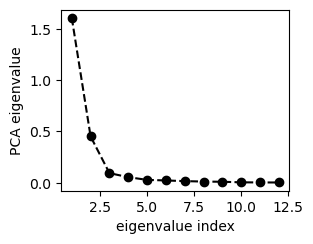

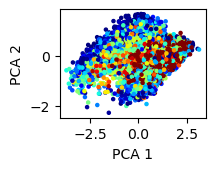

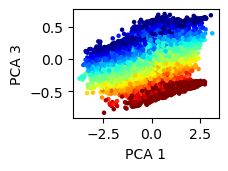

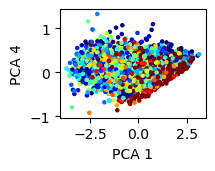

In [19]:
sctm.get_pca() #get pca coordinates from cell features
sctm.visual=True; sctm.plot_pca(colors=sctm.Xf[:,sctm.indfcb[0]]) #the feature being colored is practically the fraction of the cell boundary making cell-cell contact

Lets see what typical single-cell trajectories look like in the cell morphology feature PCA space.

In [94]:
sctm.get_unique_trajectories() #assemble trajectories from cell tracking linkages
traj_lengths=np.array([])
for itraj in range(len(sctm.trajectories)): #iterate over trajectories and get trajectory lengths
    traj_lengths=np.append(traj_lengths,sctm.trajectories[itraj].size)
    
indtrajs=np.argsort(traj_lengths)

tracked cell 7486, 1 tracks, 7400 left
tracked cell 7399, 1 tracks, 7300 left
tracked cell 7163, 1 tracks, 7000 left
tracked cell 7090, 1 tracks, 6900 left
tracked cell 6732, 5 tracks, 6500 left
tracked cell 6469, 2 tracks, 6200 left
tracked cell 6363, 2 tracks, 6100 left
tracked cell 6150, 1 tracks, 5900 left
tracked cell 6025, 1 tracks, 5800 left
tracked cell 5962, 2 tracks, 5700 left
tracked cell 5793, 1 tracks, 5400 left
tracked cell 5506, 1 tracks, 5100 left
tracked cell 5177, 1 tracks, 4800 left
tracked cell 5067, 1 tracks, 4700 left
tracked cell 4963, 2 tracks, 4600 left
tracked cell 4900, 1 tracks, 4500 left
tracked cell 4403, 1 tracks, 4100 left
tracked cell 3982, 1 tracks, 3600 left
tracked cell 3630, 1 tracks, 3300 left
tracked cell 3547, 1 tracks, 3200 left
tracked cell 3417, 3 tracks, 3100 left
tracked cell 3326, 1 tracks, 3000 left
tracked cell 3206, 1 tracks, 2900 left
tracked cell 3060, 3 tracks, 2800 left
tracked cell 2685, 2 tracks, 2500 left
tracked cell 2501, 1 trac

In [42]:
def show_cell_trajectory(self,cell_traj,x=None,traj=None,nbins=20): #make a plot of cell coordinate and single-cell images along a cell trajectory
    if x is None:
        x=self.Xtraj
    if traj is None:
        traj=self.traj
    plt.figure(figsize=(9,4))
    prob,xedges1,yedges1=np.histogram2d(x[:,0],x[:,1],bins=nbins,density=True) #coordinate landscape probability distribution
    xx,yy=np.meshgrid(.5*xedges1[1:]+.5*xedges1[0:-1],.5*yedges1[1:]+.5*yedges1[0:-1]) #grid coordinates
    xt,inds_traj=sctm.get_Xtraj_celltrajectory(cell_traj,Xtraj=x,traj=traj) #get coordinates, cell indices along trajectory set
    cell_traj=sctm.traj[inds_traj,-1]
    nt=cell_traj.size
    icell=cell_traj[-1]; iS=1;
    for itt in range(nt):
        clear_output(wait=True)
        plt.clf()
        plt.subplot(1,2,1)
        cs=plt.contourf(xx,yy,prob.T,cmap=plt.cm.Greys,extend='both')
        cs.cmap.set_over('black')
        plt.axis('off')
        ax=plt.gca()
        for ittt in range(itt-1):
            ax.arrow(xt[ittt,0],xt[ittt,1],xt[ittt+1,0]-xt[ittt,0],xt[ittt+1,1]-xt[ittt,1],head_width=.2,linewidth=1.0,color=plt.cm.winter(ittt/nt),alpha=1.0)
        plt.subplot(1,2,2)
        sctm.get_cellborder_images(indcells=np.array([cell_traj[itt]]),bordersize=80)
        imgcell=sctm.cellborder_imgs[0]
        mskcell=sctm.cellborder_msks[0]
        fmskcell=sctm.cellborder_fmsks[0]
        ccborder,csborder=sctm.get_cc_cs_border(mskcell,fmskcell)
        plt.imshow(np.ma.masked_where(fmskcell == 0, imgcell),cmap=plt.cm.seismic,clim=(-10,10),alpha=1.0)
        plt.imshow(np.ma.masked_where(fmskcell == 1, imgcell),cmap=plt.cm.gray,clim=(-10,10),alpha=0.6)
        nx=imgcell.shape[0]; ny=imgcell.shape[1]
        xxc,yyc=np.meshgrid(np.arange(nx),np.arange(ny),indexing='ij')
        cmskx=np.sum(np.multiply(xxc,mskcell))/np.sum(mskcell)
        cmsky=np.sum(np.multiply(yyc,mskcell))/np.sum(mskcell)
        scatter_x=plt.scatter(cmsky,cmskx,s=600,color='black',marker='x',alpha=0.6)
        plt.axis('off')
        plt.pause(.33)

extracting cellborders from frame 87 image 0
cell: 1 smaller than minsize of 1


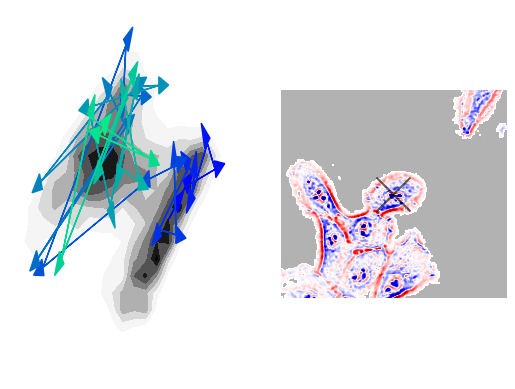

In [120]:
sctm.trajl=1
sctm.traj=sctm.get_traj_segments(1) #get trajectory segments, to be consistent with trajectory embeddings
cell_traj=sctm.trajectories[indtrajs[-6]]
show_cell_trajectory(sctm,cell_traj,x=sctm.Xpca[:,0:2],traj=sctm.traj)

In the single-timepoint morphological feature space the trajectory appears pretty random. Now lets see what this trajectory looks like in a morphodynamical trajectory embedding space (trajectory length of 8, or 3.5 hours)

In [121]:
sctm.get_trajectory_embedding(8,embedding_type='UMAP',neigen=2,get_trajectories=False) #concatenates pca features along trajectories of length 11 (5 hours), and then embeds morphodynamical feature trajectory into a UMAP of dimension 2 

extracting cellborders from frame 87 image 0
cell: 1 smaller than minsize of 1


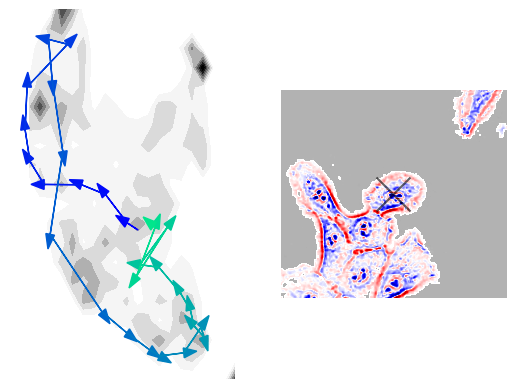

In [122]:
show_cell_trajectory(sctm,sctm.trajectories[indtrajs[-6]],x=sctm.Xtraj,traj=sctm.traj)

In the morphodynamical trajectory embedding space, you can begin to see consistent cell state transition pathways even in this single condition and single field-of-view limited dataset. 